In [ ]:
try:
  # This command only in Colab.
  # !pip install tensorflow
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [ ]:
print(total_train)

2001


In [ ]:
# 3

# 1. Create ImageDataGenerator objects
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# 2. Flow images from directories
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',   # cats vs dogs → binary classification
    shuffle=True
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = ['test'],
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


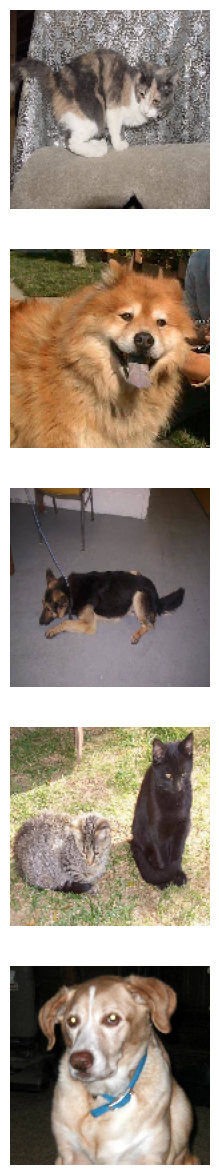

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# Augmented image generator for training
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Fills empty pixels after transformations
)

Found 2000 images belonging to 2 classes.


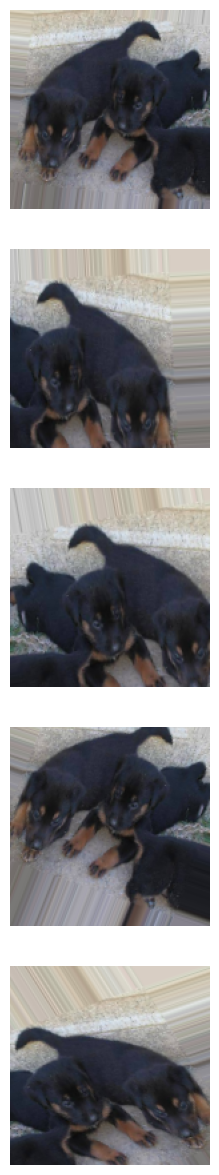

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

### Attempt 1- Building basic CNN architecture.

In [ ]:
# # 7 Model_1
# model_01 = Sequential()
# model_01.add(Conv2D(input_shape=[150, 150, 3], filters=32, kernel_size=3, padding='same', activation='relu'))
# model_01.add(MaxPooling2D(padding='same', strides=2))
# model_01.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model_01.add(MaxPooling2D(padding='same', strides=2))
# model_01.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model_01.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model_01.add(MaxPooling2D(padding='same', strides=2))
# model_01.add(Flatten())
# model_01.add(Dense(units=64, activation='relu'))
# model_01.add(Dropout(0.2))
# model_01.add(Dense(units=1, activation='sigmoid'))

# model_01.compile(
#     optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
#     loss = 'binary_crossentropy',
#     metrics =['accuracy']
# )

# model_01.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,198,273 (12.20 MB)

 Trainable params: 3,198,273 (12.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # 8 Model_1

# from math import ceil
# history_01 = model_01.fit(train_data_gen, validation_data=val_data_gen,
#                     epochs=epochs, steps_per_epoch = int(ceil(total_train/batch_size)),
#                     validation_steps=int(ceil(total_val)/batch_size))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 210s 13s/step - accuracy: 0.5025 - loss: 0.6928 - val_accuracy: 0.4955 - val_loss: 0.6911
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 263s 17s/step - accuracy: 0.5186 - loss: 0.6914 - val_accuracy: 0.5246 - val_loss: 0.6895
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 262s 17s/step - accuracy: 0.5483 - loss: 0.6904 - val_accuracy: 0.5056 - val_loss: 0.6902
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 210s 13s/step - accuracy: 0.5370 - loss: 0.6913 - val_accuracy: 0.5681 - val_loss: 0.6875
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 13s/step - accuracy: 0.5512 - loss: 0.6890 - val_accuracy: 0.6172 - val_loss: 0.6854
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 264s 17s/step - accuracy: 0.5350 - loss: 0.6901 - val_accuracy: 0.5681 - val_loss: 0.6854
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 263s 17s/step - accuracy: 0.5167 - loss: 0.6907 - val_accuracy: 0.6161 - val_loss: 0.6835
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 206s 13s/step - accuracy: 0.5482 - loss: 0.6865 - val_accuracy: 0.

### Attempt 2 - Using transfer learning

I tried building my own convnet with basic architecture for my model__01. The model didn't really perfoem well. So i will now use transfer learning by implementing pretrained base for better fine-tuned performance

In [ ]:
#7 Model_2

# Load MobileNetV2 as base model
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,       # Remove default classifier head
    weights='imagenet'       # Use pretrained weights
)

# Freeze base layers for feature extraction
base_model.trainable = False


# Build our model on top of MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),         # Flatten feature maps smartly
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')    # Binary output: cat or dog
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-1148254963.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 8 Model_2

from math import ceil
history = model.fit(train_data_gen, validation_data=val_data_gen,
                    epochs=epochs, steps_per_epoch = int(ceil(total_train/batch_size)),
                    validation_steps=int(ceil(total_val)/batch_size))

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.5007 - loss: 0.8517 - val_accuracy: 0.8906 - val_loss: 0.3019
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.8039 - loss: 0.4199 - val_accuracy: 0.9330 - val_loss: 0.1830
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.8542 - loss: 0.3238 - val_accuracy: 0.9408 - val_loss: 0.1708
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.8734 - loss: 0.2836 - val_accuracy: 0.9442 - val_loss: 0.1559
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.8760 - loss: 0.2840 - val_accuracy: 0.9464 - val_loss: 0.1490
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.8890 - loss: 0.2564 - val_accuracy: 0.9498 - val_loss: 0.1408
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.8960 - loss: 0.2412 - val_accuracy: 0.9498 - val_loss: 0.1352
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.9021 - loss: 0.2193 - val_accuracy: 0.9509 - val_l

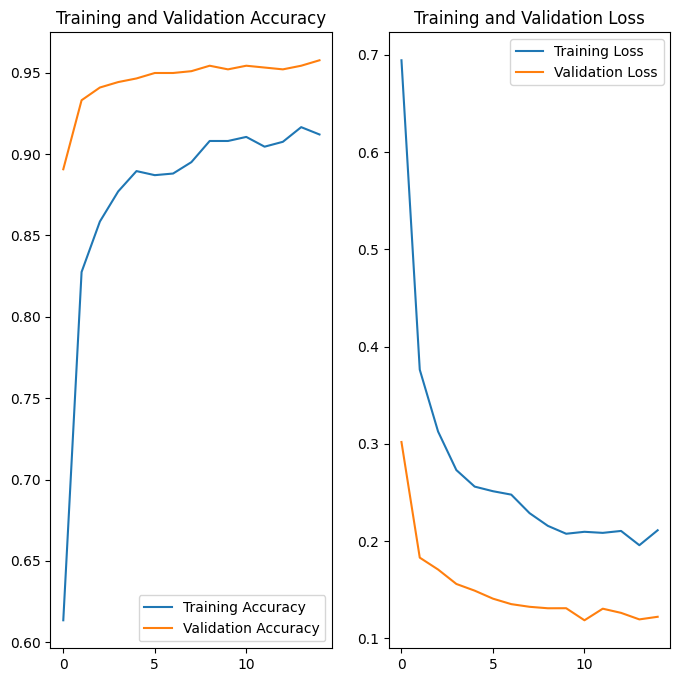

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
probabilities = model.predict(test_data_gen, steps=len(test_data_gen), verbose=1)

probabilities = probabilities.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
test_images, _ = next(test_data_gen)  # Grabs one full batch (50 images)

# 4. Plot images + model predictions
plotImages(test_images, probabilities)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 94.0% of the images of cats and dogs.
You passed the challenge!
